# Find Classwise Accuracy

In [108]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution()
import sys
sys.path.append("../utils/.")
from utils import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_random_seed(13)

import py3nvml
py3nvml.grab_gpus(1)

1

In [109]:
num_steps = 10
# model_path = "trained_models_acc/multistep/LSTM3_10steps.h5"
model_path = "trained_models_acc/multistep/LSTM3_10steps_dropzero.h5"

# model_path = "trained_models_acc/multistep/LSTM3_10steps_small_pool.h5"


# Load the dataset

In [110]:
dataset = np.load('../data/acc/compressed/full_data.npy')
# dataset = np.load('../data/acc/compressed_pool/full_data.npy')
print("Before: ", dataset.shape)
#Swap axes
dataset = dataset.swapaxes(1, -1)

#Combine station and xyz
#dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], -1)
print("After: ", dataset.shape)

Before:  (35679, 15, 60)
After:  (35679, 60, 15)


In [111]:
richters_path = "../data/metadata/richters.npy"
richters = np.load(richters_path)
print(len(richters))
print(min(richters), max(richters))

classes = [0, 1, 2, 3]
richters_discrete = np.zeros_like(richters)
richters_discrete += np.where(richters >= 5., np.ones_like(richters), np.zeros_like(richters))
richters_discrete += np.where(richters >= 3., np.ones_like(richters), np.zeros_like(richters))
richters_discrete += np.where(richters >= 1., np.ones_like(richters), np.zeros_like(richters))

35679
-0.49 7.1


Text(0, 0.5, 'Num Earthquakes')

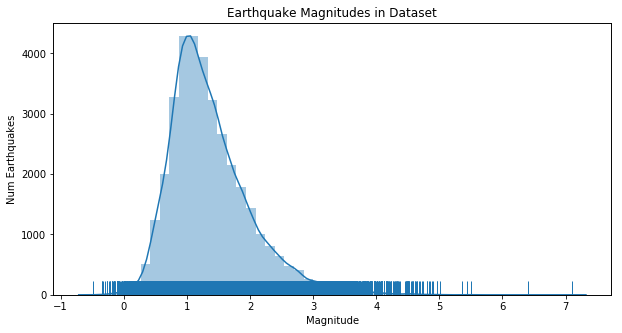

In [112]:
# Characterize the magnitudes
import seaborn as sns
f,ax1 = plt.subplots(figsize=(10, 5))
sns.distplot(richters,kde=False,ax=ax1, rug=True)
ax2 = ax1.twinx()
ax2.yaxis.set_ticks([])
sns.kdeplot(richters,ax=ax2)
plt.title("Earthquake Magnitudes in Dataset")
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('Num Earthquakes')

In [113]:
dataset, richters_discrete = shuffle_together(dataset, richters_discrete)

In [114]:
data_mean = np.mean(dataset, axis = 1)
data_var = np.linalg.norm(dataset - np.expand_dims(data_mean, 1), axis = 1)

#Add some epsilon to make the divide by zero var work
epsilon = 1
data_var[data_var == 0] = epsilon
data_var[data_var == 0] = epsilon

dataset = (dataset - np.expand_dims(data_mean, 1))/np.expand_dims(data_var, 1)

# Segment earthquakes by magnitude

(array([1.0728e+04, 0.0000e+00, 0.0000e+00, 2.3971e+04, 0.0000e+00,
        0.0000e+00, 9.7400e+02, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

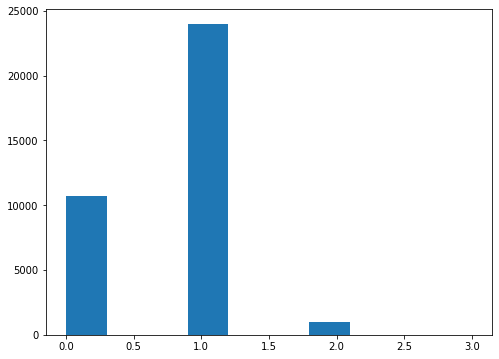

In [115]:
plt.hist(richters_discrete)

In [116]:
TRAIN_SPLIT_IDX = int(dataset.shape[0]*0.8)
val_dataset = dataset[TRAIN_SPLIT_IDX:]
val_richters_discrete = richters_discrete[TRAIN_SPLIT_IDX:]
val_data_mean = data_mean[TRAIN_SPLIT_IDX:]
val_data_var = data_var[TRAIN_SPLIT_IDX:]


quakes0 = val_dataset[val_richters_discrete == 0]
val_data_mean0 = val_data_mean[val_richters_discrete == 0]
val_data_var0 = val_data_var[val_richters_discrete == 0]

quakes1 = val_dataset[val_richters_discrete == 1]
val_data_mean1 = val_data_mean[val_richters_discrete == 1]
val_data_var1 = val_data_var[val_richters_discrete == 1]

quakes2 = val_dataset[val_richters_discrete == 2]
val_data_mean2 = val_data_mean[val_richters_discrete == 2]
val_data_var2 = val_data_var[val_richters_discrete == 2]

quakes3 = val_dataset[val_richters_discrete == 3]
val_data_mean3 = val_data_mean[val_richters_discrete == 3]
val_data_var3 = val_data_var[val_richters_discrete == 3]

len(quakes0), len(quakes1), len(quakes2), len(quakes3)

(2168, 4778, 188, 2)

In [117]:
past_history = 15
future_target =  num_steps
STEP = 1

x_0, y_0 = multivariate_data(quakes0,past_history,
                                                   future_target, STEP,
                                                   single_step= (num_steps == 1))
x_1, y_1 = multivariate_data(quakes1,past_history,
                                                   future_target, STEP,
                                                   single_step= (num_steps == 1))
x_2, y_2 = multivariate_data(quakes2,past_history,
                                                   future_target, STEP,
                                                   single_step= (num_steps == 1))
x_3, y_3 = multivariate_data(quakes3,past_history,
                                                   future_target, STEP,
                                                   single_step= (num_steps == 1))

x_0.shape, x_1.shape, x_2.shape, x_3.shape 

((75880, 15, 15), (167230, 15, 15), (6580, 15, 15), (70, 15, 15))

In [118]:
x_0.shape, y_0.shape

((75880, 15, 15), (75880, 10, 15))

# Load the model

In [119]:
# Smaller model
inp_shape = (15, 15)
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=inp_shape))
single_step_model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'))
single_step_model.add(tf.keras.layers.LSTM(64, activation='relu'))
single_step_model.add(tf.keras.layers.Dense(15*num_steps))

single_step_model.load_weights(model_path)

single_step_model.compile(optimizer='nadam', loss='mae', metrics=['mae', 'mse'])
single_step_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 15, 128)           73728     
_________________________________________________________________
lstm_13 (LSTM)               (None, 15, 64)            49408     
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 150)               9750      
Total params: 165,910
Trainable params: 165,910
Non-trainable params: 0
_________________________________________________________________


In [120]:
# # Larger Model

# single_step_model = tf.keras.models.Sequential()
# single_step_model.add(tf.keras.layers.LSTM(256,
#                                           return_sequences=True,
#                                           input_shape=x_0.shape[-2:]))
# single_step_model.add(tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'))
# single_step_model.add(tf.keras.layers.LSTM(128, activation='relu'))
# single_step_model.add(tf.keras.layers.Dense(15*num_steps))

# single_step_model.load_weights(model_path)

# single_step_model.compile(optimizer='nadam', loss='mae', metrics=['mae', 'mse'])
# single_step_model.summary()

In [121]:
y_pred_0 = single_step_model.predict(x_0, batch_size = 4096).reshape((-1, 10, 15))[:, -1, :]
y_pred_1 = single_step_model.predict(x_1, batch_size = 4096).reshape((-1, 10, 15))[:, -1, :]
y_pred_2 = single_step_model.predict(x_2, batch_size = 4096).reshape((-1, 10, 15))[:, -1, :]
y_pred_3 = single_step_model.predict(x_3, batch_size = 4096).reshape((-1, 10, 15))[:, -1, :]

y_0 = y_0[:, -1, :]
y_1 = y_1[:, -1, :]
y_2 = y_2[:, -1, :]
y_3 = y_3[:, -1, :]

In [122]:
y_0.shape

(75880, 15)

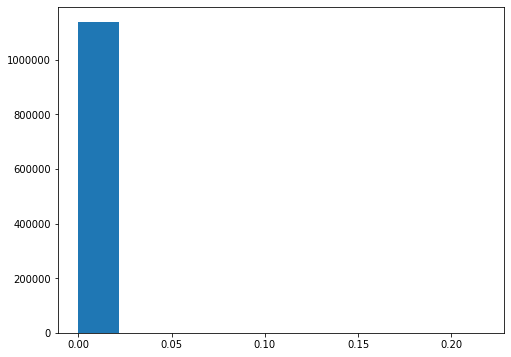

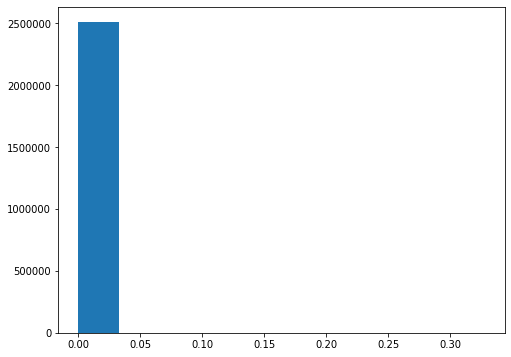

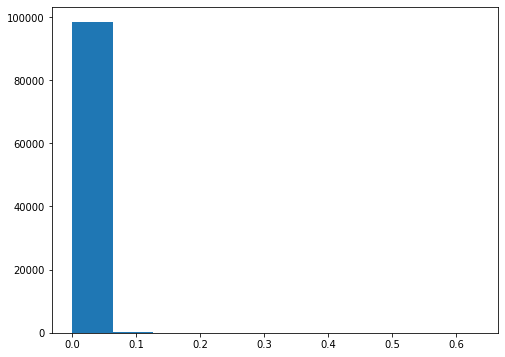

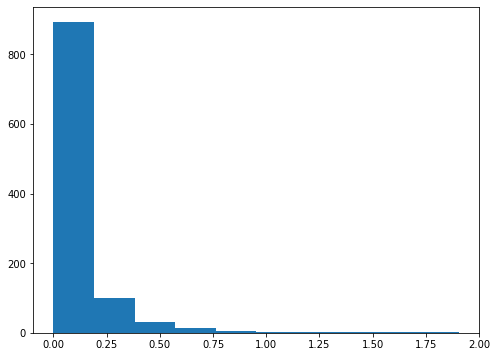

In [123]:
recovered_y_0, recovered_y_pred_0, delta_0 = recover_quake(y_pred_0, y_0, val_data_mean0, val_data_var0, len(quakes0))
recovered_y_1, recovered_y_pred_1, delta_1 = recover_quake(y_pred_1, y_1, val_data_mean1, val_data_var1, len(quakes1))
recovered_y_2, recovered_y_pred_2, delta_2 = recover_quake(y_pred_2, y_2, val_data_mean2, val_data_var2, len(quakes2))
recovered_y_3, recovered_y_pred_3, delta_3 = recover_quake(y_pred_3, y_3, val_data_mean3, val_data_var3, len(quakes3))

plt.figure()
plt.hist(delta_0)
plt.show()

plt.figure()
plt.hist(delta_1)
plt.show()

plt.figure()
plt.hist(delta_2)
plt.show()

plt.figure()
plt.hist(delta_3)
plt.show()

In [124]:
delta_0.shape

(1138200,)

In [125]:
def mae(delta):
    return np.mean(np.abs(delta))
mae(delta_0), mae(delta_1), mae(delta_2), mae(delta_3)

(5.419898286478012e-05,
 7.795236902265659e-05,
 0.0017449141082382439,
 0.10055656827462466)

In [102]:
mae(delta_0)/np.mean(val_data_var0), mae(delta_1)/np.mean(val_data_var1), mae(delta_2)/np.mean(val_data_var2), mae(delta_3)/np.mean(val_data_var3)

(0.051335342616138896,
 0.05870978733003937,
 0.054163878671957114,
 0.0696121938276936)

In [126]:
mae(delta_0)/np.mean(val_data_var0), mae(delta_1)/np.mean(val_data_var1), mae(delta_2)/np.mean(val_data_var2), mae(delta_3)/np.mean(val_data_var3)

(0.05206507329166346,
 0.0674936430059016,
 0.061877089629413955,
 0.06856738454343776)

In [103]:
from sklearn import metrics

for y_true, y_pred in zip([y_0, y_1, y_2, y_3], [y_pred_0, y_pred_1, y_pred_2, y_pred_3]):
    print()
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    print("Explained Variance Score:", metrics.explained_variance_score(y_true, y_pred)) 
    print("Max Error Score:", metrics.max_error(y_true, y_pred)) 
    print("Mean Absolute Error Score:", metrics.mean_absolute_error(y_true, y_pred)) 
    print("Mean Squared Error Score:", metrics.mean_squared_error(y_true, y_pred)) 
    print("Median Absolute Error Score:", metrics.median_absolute_error(y_true, y_pred)) 
    print("R2 Score:", metrics.r2_score(y_true, y_pred)) 


Explained Variance Score: 0.12597027154622653
Max Error Score: 1.0187752057129082
Mean Absolute Error Score: 0.07124642067985844
Mean Squared Error Score: 0.013278786865322951
Median Absolute Error Score: 0.03950557876711811
R2 Score: 0.1035068495877296

Explained Variance Score: 0.2987994545921048
Max Error Score: 1.0332766566680882
Mean Absolute Error Score: 0.06141426821621295
Mean Squared Error Score: 0.012039806193358642
Median Absolute Error Score: 0.0276808868294087
R2 Score: 0.2711263383859017

Explained Variance Score: 0.45475568731101224
Max Error Score: 1.0231747983308597
Mean Absolute Error Score: 0.052176421992162554
Mean Squared Error Score: 0.009706775212001644
Median Absolute Error Score: 0.02234005811922141
R2 Score: 0.43635255232216485

Explained Variance Score: 0.5570147116077654
Max Error Score: 0.5245725556142209
Mean Absolute Error Score: 0.06416758623236007
Mean Squared Error Score: 0.009595106903524558
Median Absolute Error Score: 0.03792097784908973
R2 Score: 

In [127]:
from sklearn import metrics

for y_true, y_pred in zip([y_0, y_1, y_2, y_3], [y_pred_0, y_pred_1, y_pred_2, y_pred_3]):
    print()
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    print("Explained Variance Score:", metrics.explained_variance_score(y_true, y_pred)) 
    print("Max Error Score:", metrics.max_error(y_true, y_pred)) 
    print("Mean Absolute Error Score:", metrics.mean_absolute_error(y_true, y_pred)) 
    print("Mean Squared Error Score:", metrics.mean_squared_error(y_true, y_pred)) 
    print("Median Absolute Error Score:", metrics.median_absolute_error(y_true, y_pred)) 
    print("R2 Score:", metrics.r2_score(y_true, y_pred)) 


Explained Variance Score: 0.1060857770441539
Max Error Score: 1.0245778519922433
Mean Absolute Error Score: 0.07283531029130481
Mean Squared Error Score: 0.013501580886088846
Median Absolute Error Score: 0.0415267951802579
R2 Score: 0.08846531638178368

Explained Variance Score: 0.27962517262676545
Max Error Score: 1.0415457165529438
Mean Absolute Error Score: 0.06316287137363538
Mean Squared Error Score: 0.012298841328300454
Median Absolute Error Score: 0.029569121142874747
R2 Score: 0.2554446999724953

Explained Variance Score: 0.4175733533401248
Max Error Score: 1.0216758942516608
Mean Absolute Error Score: 0.05480322837207757
Mean Squared Error Score: 0.010347543356240232
Median Absolute Error Score: 0.02395192184160002
R2 Score: 0.3991447957639632

Explained Variance Score: 0.5493090200248509
Max Error Score: 0.4884220992129309
Mean Absolute Error Score: 0.06696359417421027
Mean Squared Error Score: 0.010473479334088726
Median Absolute Error Score: 0.03863667166328704
R2 Score: 0

In [104]:
overall_mae = x_0.shape[0]*mae(delta_0)/np.mean(val_data_var0) + x_1.shape[0] * mae(delta_1)/np.mean(val_data_var1) + x_2.shape[0]*mae(delta_2)/np.mean(val_data_var2)

overall_mae /= x_0.shape[0] + x_1.shape[0] + x_2.shape[0]
overall_mae

0.05634892007920454

In [105]:
r2 = 0
for num, y_true, y_pred in zip([x_0.shape[0], x_1.shape[0], x_2.shape[0]], [y_0, y_1, y_2], [y_pred_0, y_pred_1, y_pred_2]):
    r2 += num*metrics.r2_score(y_true, y_pred)
    
print("Total R2: ", r2 / sum([x_0.shape[0], x_1.shape[0], x_2.shape[0]]))

Total R2:  0.22108892566559352


## Calculate mean absolute peak difference across stations

In [106]:
recovered_y_pred_3.shape

(2, 35, 15)

In [107]:
y_preds = [recovered_y_pred_0, recovered_y_pred_1, recovered_y_pred_2, recovered_y_pred_3]
y_trues = [recovered_y_0, recovered_y_1, recovered_y_2, recovered_y_3]
map_diffs = [0]*4

for mag in range(4):
    map_diffs[mag] = np.mean(np.abs(np.max(y_preds[mag], axis=1) - np.max(y_trues[mag], axis=1)))
#     map_diffs[mag] = np.mean(y_trues[mag])

print(map_diffs)

[0.0001313373493473066, 0.0003419728806222997, 0.008769613063940362, 0.41877629854512965]


In [128]:
y_preds = [recovered_y_pred_0, recovered_y_pred_1, recovered_y_pred_2, recovered_y_pred_3]
y_trues = [recovered_y_0, recovered_y_1, recovered_y_2, recovered_y_3]
map_diffs = [0]*4

for mag in range(4):
    map_diffs[mag] = np.mean(np.abs(np.max(y_preds[mag], axis=1) - np.max(y_trues[mag], axis=1)))
#     map_diffs[mag] = np.mean(y_trues[mag])

print(map_diffs)

[0.0001366008272111435, 0.0003366356563818395, 0.009393421883285987, 0.45003422403927706]


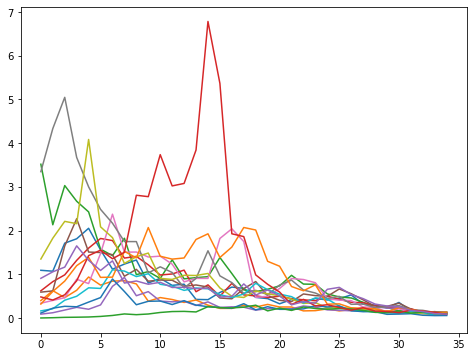

In [54]:
[0.0001313373493473066, 0.0003419728806222997, 0.008769613063940362, 0.41877629854512965]
plt.plot(recovered_y_3[0])
plt.show()